In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras 
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import warnings
warnings.filterwarnings("ignore")

In [23]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (220,220)

In [24]:
def load_data():
    datasets = ['chest_xray/train', 'chest_xray/test']
    images = []
    labels = []

    count = 0
    for dataset in datasets:
        for folder in os.listdir(dataset):
            if folder == 'NORMAL':
                label = 0
            elif folder == 'PNEUMONIA':
                label = 1
            else:
                # Skip folders that are not 'NORMAL' or 'PNEUMONIA'
                continue

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Check if the file is a valid image file
                if not os.path.isfile(img_path):
                    continue

                image = cv2.imread(img_path)
                try:
                    image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
                except:
                    continue
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    return images, labels

In [25]:
images, labels = load_data()

  0%|          | 0/3876 [00:00<?, ?it/s]

100%|██████████| 234/234 [00:04<00:00, 58.04it/s]


In [26]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.23)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [27]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Количество тренеровочных экземпляров: {}".format(n_train))
print("Количество валидационных экземпляров: {}".format(n_val))
print("Количество тестовых экземпляров: {}".format(n_test))

print("Форма тренировочной выборки: {}".format(train_images.shape))
print("Форма значений тренировочных изображений: {}".format(train_labels.shape))
print("Форма валидационной выборки: {}".format(val_images.shape))
print("Форма значений валидационных изображений: {}".format(val_labels.shape))
print("Форма тестовой выборки: {}".format(test_images.shape))
print("Форма значений тестовых изображений: {}".format(test_labels.shape))

Количество тренеровочных экземпляров: 4496
Количество валидационных экземпляров: 672
Количество тестовых экземпляров: 672
Форма тренировочной выборки: (4496, 220, 220, 3)
Форма значений тренировочных изображений: (4496,)
Форма валидационной выборки: (672, 220, 220, 3)
Форма значений валидационных изображений: (672,)
Форма тестовой выборки: (672, 220, 220, 3)
Форма значений тестовых изображений: (672,)


In [28]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

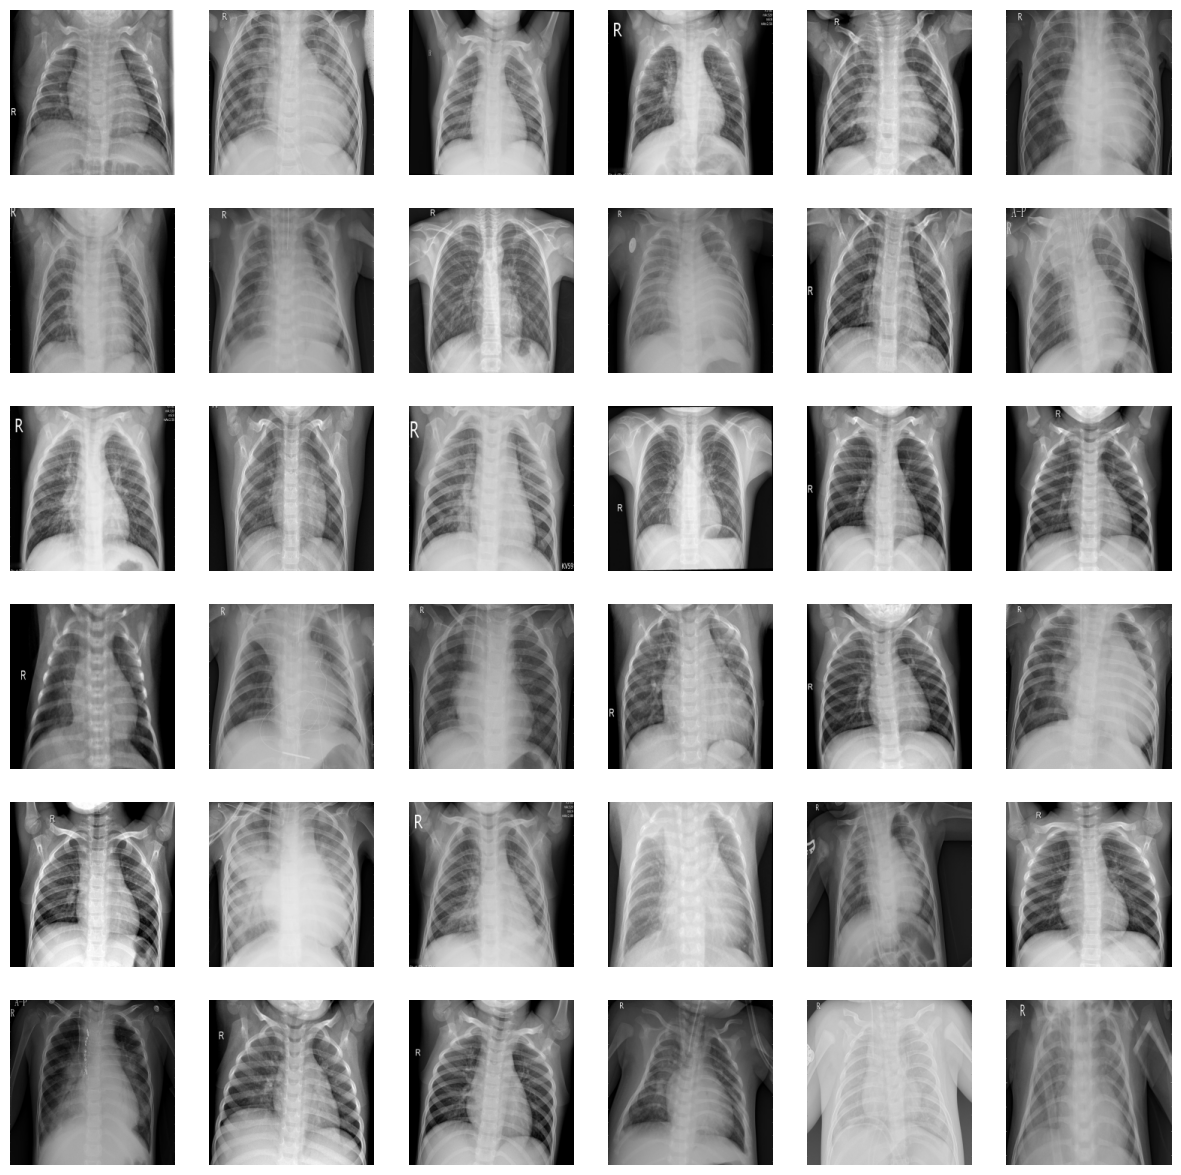

In [29]:
plt.figure(figsize=(15,15))
for n,i in enumerate(list(np.random.randint(0,len(train_images),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.axis("off")

In [32]:
# resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

# Load the DenseNet121 model with local weights file
resnet50 = ResNet50V2(input_shape=(220,220,3), weights='/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Pneumonia_models/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

In [33]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [34]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36410113 (138.89 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [36]:
tf.keras.utils.plot_model(
    model, show_layer_names=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
pip install graphviz


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
history = model.fit(
    x = train_images, 
    y = train_labels, 
    batch_size = 16, 
    epochs = 10, 
    validation_data=(val_images, val_labels)
)

Epoch 1/10
281/281 [==============================] - 162s 571ms/step - loss: 0.8748 - accuracy: 0.9181 - val_loss: 0.1191 - val_accuracy: 0.9554
Epoch 2/10
281/281 [==============================] - 177s 629ms/step - loss: 0.1715 - accuracy: 0.9495 - val_loss: 0.1816 - val_accuracy: 0.9554
Epoch 3/10
281/281 [==============================] - 187s 665ms/step - loss: 0.1332 - accuracy: 0.9589 - val_loss: 0.0992 - val_accuracy: 0.9702
Epoch 4/10
281/281 [==============================] - 199s 709ms/step - loss: 0.1050 - accuracy: 0.9684 - val_loss: 0.1081 - val_accuracy: 0.9628
Epoch 5/10
281/281 [==============================] - 401s 1s/step - loss: 0.0834 - accuracy: 0.9704 - val_loss: 0.1355 - val_accuracy: 0.9673
Epoch 6/10
281/281 [==============================] - 387s 1s/step - loss: 0.0644 - accuracy: 0.9738 - val_loss: 0.1190 - val_accuracy: 0.9628
Epoch 7/10
281/281 [==============================] - 427s 2s/step - loss: 0.0534 - accuracy: 0.9802 - val_loss: 0.1022 - val_accu